# Word Correlation Analysis

In [1]:
import collections
import itertools
import logging
import os.path
import pickle
import warnings

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(name)s: %(message)s")

import data

/mnt/c/Users/koerner/Desktop/robert-power-and-language-files-osf/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare data

In [2]:
fn_study_prepared = "studydata.pickle"

if not os.path.exists(fn_study_prepared):
    df_study1, df_study2 = data.prepare_study_data()

    with open(fn_study_prepared, "wb") as fp:
        pickle.dump(df_study1, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(df_study2, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open(fn_study_prepared, "rb") as fp:
    df_study1 = pickle.load(fp)
    df_study2 = pickle.load(fp)

df_study1, df_study2 = data.clean_study_data(df_study1, df_study2, do_clean_stopwords=False)

[INFO] data: Clean study data ...


In [3]:
df_study = df_study1

hier_var_cols = ["power", "prestige", "dominance", "power_f", "prestige_f", "dominance_f"]
if "workplace_power" in df_study.columns:
    hier_var_cols += ["workplace_power", "workplace_power_f"]

In [4]:
print(f"Number of documents: {len(df_study)}")

df_scores = df_study[hier_var_cols]


# preprocessed documents (spacy tokenized, some filtering of non-words)
df_documents = df_study["text_spacy_doc_filtered"]

# NOTE: (do) we want to keep the stopwords?
#df_documents = df_study["text_spacy_doc"]
#df_documents = data.clean(df_documents, stopwords=False, alpha=True, punctuation=True)


# get plain list of tokens per document (no lemmatizing)
df_tokens = data.get_tokens_by_pos(df_documents, pos_list=None, lemma=False, join=False)
#df_scores["tokens"] = df_tokens


Number of documents: 200


## Analysis of Top-Words and Split-Half Correlation

In [5]:
# count number of tokens
def _count_tokens_fn(doc):
    num_tokens = len(doc)
    cnt = collections.Counter(doc)
    return {word: num / num_tokens for word, num in cnt.items()}

df_tokens_weighted = df_tokens.map(_count_tokens_fn)


# get N-most frequently occuring words (based on relative counts)
types = collections.Counter()
for doc in df_tokens_weighted.values.tolist():
    types.update(doc)

print(f"Number of types (unique word forms): {len(types)}")
print()

# set cutoff
N = len(types)
N = 1000

types_top_N = types.most_common(N)
print(f"Top-10 Types: {', '.join('{} ({:.2f})'.format(w, c) for w, c in types_top_N[:10])}")
print(f"Bottom-10 Types: {', '.join('{} ({:.2f})'.format(w, c) for w, c in types_top_N[-10:])}")
types_top_N = dict(types_top_N)


# filter out types in documents that are not in top-N
types_to_keep = set(types_top_N.keys())
def _filter_tokens_fn(doc):
    return {k: v for k, v in doc.items() if k in types_to_keep}

df_tokens_weighted_filtered = df_tokens_weighted.map(_filter_tokens_fn)

Number of types (unique word forms): 2529

Top-10 Types: Ich (11.33), und (11.22), bin (8.79), ich (5.26), mich (3.14), sehr (3.07), zu (2.76), ein (2.46), in (2.12), mit (2.03)
Bottom-10 Types: schätze (0.03), Dorf (0.03), Andererseits (0.03), Tage (0.03), bleiben (0.03), besuchen (0.03), erwachsene (0.03), durchsetzungsstark (0.03), Kompromisse (0.03), eingehe (0.03)


In [6]:
# get updated token weights --> since total token count changed, recompute
def _count_tokens_filtered_fn(doc):
    cnt = collections.Counter(doc)
    cnt = {k: v for k, v in cnt.items() if k in types_to_keep}
    num_tokens = sum(cnt.values())
    return {word: num / num_tokens for word, num in cnt.items()}

df_tokens_weighted_filtered = df_tokens.map(_count_tokens_filtered_fn)

types = collections.Counter()
for doc in df_tokens_weighted_filtered.values.tolist():
    types.update(doc)

types_top_N = types.most_common(N)
print(f"Top-10 Types: {', '.join('{} ({:.2f})'.format(w, c) for w, c in types_top_N[:10])}")
print(f"Bottom-10 Types: {', '.join('{} ({:.2f})'.format(w, c) for w, c in types_top_N[-10:])}")
types_top_N = dict(types_top_N)

Top-10 Types: und (12.99), Ich (12.69), bin (9.91), ich (6.33), mich (3.65), sehr (3.47), zu (3.29), ein (2.79), in (2.50), mit (2.43)
Bottom-10 Types: Golf (0.03), Lethargie (0.03), belastet (0.03), zuweilen (0.03), Serien (0.03), laufe (0.03), umsetzen (0.03), übergewichtig (0.03), gespaltenes (0.03), Körper (0.03)


In [7]:
# compute word rank and than split-half-correlation
random_state = 42  # for reproducibility
idx_shuffled = shuffle(df_tokens_weighted_filtered.index.values, random_state=random_state)
half_1, half_2 = idx_shuffled[:len(idx_shuffled) // 2], idx_shuffled[len(idx_shuffled) // 2:]
df_tok_1, df_tok_2 = df_tokens_weighted_filtered[half_1], df_tokens_weighted_filtered[half_2]

def _get_ranks(df_doc):
    types = collections.Counter()
    for doc in df_doc.values.tolist():
        types.update(doc)
    ordered = types.most_common()
    return {word: rank for rank, (word, _) in enumerate(ordered, 1)}

ranks_1, ranks_2 = _get_ranks(df_tok_1), _get_ranks(df_tok_2)
print("Ranks (half/1): ", ", ".join(w for w, _ in list(ranks_1.items())[:10]))
print("Ranks (half/2): ", ", ".join(w for w, _ in list(ranks_2.items())[:10]))
print()

ranklist_1 = np.array([ranks_1.get(word, None) for word in types_top_N.keys()], dtype=np.float)
ranklist_2 = np.array([ranks_2.get(word, None) for word in types_top_N.keys()], dtype=np.float)
# pd.DataFrame([types_all, ranklist_1, ranklist_2]).T.rename(columns={1: "words", 1: "half-1", 2: "half-2"})

res = scipy.stats.spearmanr(ranklist_1, ranklist_2, nan_policy="omit", alternative="greater")
print(res)
print()

for cutoff in (10, 20, 50, 100, 200, 500, 750, 1000):
    ranklist_1_sub, ranklist_2_sub = ranklist_1[:cutoff], ranklist_2[:cutoff]

    res = scipy.stats.spearmanr(ranklist_1_sub, ranklist_2_sub, nan_policy="omit")
    print(f"top-{cutoff}: {res.correlation=}")


Ranks (half/1):  und, Ich, bin, ich, zu, sehr, mich, in, ein, mit
Ranks (half/2):  Ich, und, bin, ich, mich, sehr, ein, zu, mit, die

SpearmanrResult(correlation=0.5622895940938863, pvalue=8.591768161160716e-50)

top-10: res.correlation=0.8545454545454544
top-20: res.correlation=0.9233082706766916
top-50: res.correlation=0.8915726290516206
top-100: res.correlation=0.7727572757275726
top-200: res.correlation=0.610360895386021
top-500: res.correlation=0.5065665496022397
top-750: res.correlation=0.5388024276906572
top-1000: res.correlation=0.5622895940938863


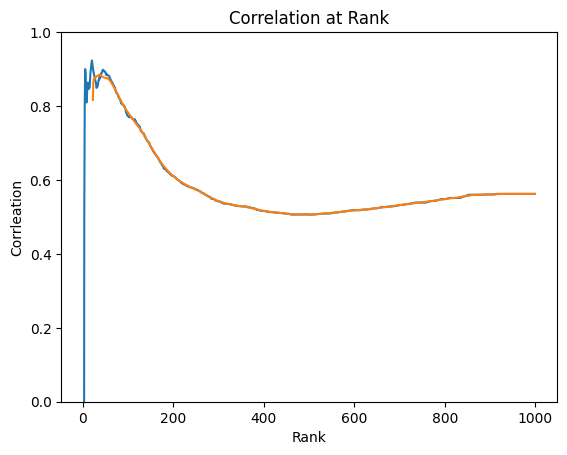

In [8]:
ranks = np.arange(1, N)
corrs = np.array([scipy.stats.spearmanr(ranklist_1[:cutoff], ranklist_2[:cutoff], nan_policy="omit").correlation for cutoff in ranks])

# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
# https://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python/34387987#34387987

from scipy.signal import savgol_filter
corrshat = savgol_filter(corrs, 41, 1) # window size 51, polynomial order 1

# def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='same')
#     return y_smooth
# corrshat = smooth(corrs, 51)

# import statsmodels as sm
# import statsmodels.nonparametric.smoothers_lowess
# win = 31
# corrshat = sm.nonparametric.smoothers_lowess.lowess(corrs, ranks, frac=(5*win / len(corrs)), return_sorted=False)

plt.plot(ranks, corrs)
plt.plot(ranks, corrshat)
plt.title("Correlation at Rank")
plt.ylabel("Corrleation")
plt.xlabel("Rank")
plt.ylim((0, 1))
plt.show()

In [9]:
# ?

if False:
    start = 500
    ende = 750
    ranks = np.arange(start + 10, ende)
    corrs = np.array([scipy.stats.spearmanr(ranklist_1[start:cutoff], ranklist_2[start:cutoff], nan_policy="omit").correlation for cutoff in ranks])

    # https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
    # https://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python/34387987#34387987

    from scipy.signal import savgol_filter
    corrshat = savgol_filter(corrs, 41, 1) # window size 51, polynomial order 1

    plt.plot(ranks, corrs)
    plt.plot(ranks, corrshat)
    plt.title("Correlation at Rank")
    plt.ylabel("Corrleation")
    plt.xlabel("Rank")
    #plt.ylim((0, 1))
    plt.show()

## Hierarchy Variable -- Word Correlation

In [10]:
# build a feature matrix (relative word frequency per document)
mat, words = data.build_feature_matrix(df_documents)
df_features = pd.DataFrame(mat.todense())
df_features.columns = words

col_prefix = "hierarchy_variables:"
df_scores_prefixed = df_scores.add_prefix(col_prefix)
hier_var_cols_prefixed = ["{}{}".format(col_prefix, col) for col in hier_var_cols]

# add hierarchy variables
df_features = pd.merge(df_features, df_scores_prefixed, left_index=True, right_index=True)

# correlate
df_corrs = df_features.corr()

# just keep hierarchy variable colums
# (correlation hierarchy variable to words, based on score)
df_corrs = df_corrs[hier_var_cols_prefixed]

df_hier_vars_corrs = df_corrs.loc[hier_var_cols_prefixed].rename(columns=dict(zip(hier_var_cols_prefixed, hier_var_cols)))

# remove correlation
df_corrs = df_corrs.drop(hier_var_cols_prefixed)
# df_corrs = df_corrs.drop(df_corrs.tail(len(hier_var_cols)).index)

df_corrs = df_corrs.rename(columns=dict(zip(hier_var_cols_prefixed, hier_var_cols)))

In [11]:
df_hier_vars_corrs.style.text_gradient(axis=0)

,power,prestige,dominance,power_f,prestige_f,dominance_f
hierarchy_variables:power,1.000000,0.617600,0.382244,0.504424,0.417322,0.286030
hierarchy_variables:prestige,0.617600,1.000000,0.197145,0.385797,0.388594,0.232336
hierarchy_variables:dominance,0.382244,0.197145,1.000000,0.311947,0.048311,0.478114
hierarchy_variables:power_f,0.504424,0.385797,0.311947,1.000000,0.710974,0.724672
hierarchy_variables:prestige_f,0.417322,0.388594,0.048311,0.710974,1.000000,0.211493
hierarchy_variables:dominance_f,0.286030,0.232336,0.478114,0.724672,0.211493,1.000000


In [12]:
df_corrs

,power,prestige,dominance,power_f,prestige_f,dominance_f
Ich,0.038497,0.014991,0.074891,0.001607,0.062716,-0.051770
würde,-0.026042,0.041191,0.016521,-0.010656,0.012728,-0.014885
mich,-0.032368,0.050851,-0.067033,-0.145022,-0.008802,-0.160067
selbst,-0.065825,0.010965,-0.025461,0.054651,0.073652,0.039441
als,-0.051067,-0.086463,-0.021728,0.027788,-0.039693,0.022791
...,...,...,...,...,...,...
Nachbarschaft,0.107112,0.064887,0.035782,0.024983,0.006408,0.021280
humorvolle,0.053122,0.076404,0.027540,0.068192,0.029753,0.064251
künstlerisch,0.053122,0.076404,0.027540,0.068192,0.029753,0.064251
begabte,0.053122,0.076404,0.027540,0.068192,0.029753,0.064251


In [13]:
# filter top-N per variable
N = 10

# only filter out those per variable with N highest absolute values
mask = np.zeros_like(df_corrs.index).astype(bool)
for col in hier_var_cols:
    srt = np.argsort(df_corrs[col].abs())[::-1]
    #print(f"Top-{N} of '{col}':", ", ".join("{} ({:.2f})".format(w, v) for w, v in df_corrs[col][srt][:N].to_dict().items()))
    mask[srt[:N]] = True

# np.unique(mask, return_counts=True)

mask = pd.Series(mask, index=df_corrs.index)
df_corrs_sub = df_corrs[mask]

#df_corrs_sub[[col]].style.highlight_between(left=min, right=max)
df_corrs_sub

,power,prestige,dominance,power_f,prestige_f,dominance_f
Empathie,0.107162,0.086889,0.118421,0.180153,0.157276,0.134368
aber,-0.024738,0.016162,0.045051,-0.082164,-0.220422,0.053211
nicht,-0.143433,-0.021029,-0.050482,-0.164498,-0.207136,-0.010254
schwer,-0.206952,-0.058267,-0.079109,-0.241227,-0.157456,-0.187268
schon,0.087099,0.013652,0.062072,0.183762,0.186352,0.102806
halte,-0.090988,-0.003428,-0.081833,-0.168624,-0.208594,-0.072084
öfter,-0.054457,-0.019852,-0.022759,-0.193411,-0.091496,-0.116323
Stärken,0.133622,0.149163,0.253114,0.168380,0.058964,0.184475
introvertiert,-0.164788,-0.048938,-0.154508,-0.232370,-0.148632,-0.173565
ruhiger,-0.106748,-0.097617,-0.084970,-0.222237,-0.108746,-0.142355


In [14]:
# filter top-N per variable
N = 10
topn_half = N // 2 + 1

# only filter out those per variable with N highest absolute values
mask = np.zeros_like(df_corrs.index).astype(bool)
for col in hier_var_cols:
    srt = np.argsort(df_corrs[col])[::-1]
    print(f"Pos-Top-{topn_half} of '{col}':", ", ".join("{} ({:.2f})".format(w, v) for w, v in df_corrs[col][srt][:topn_half].to_dict().items()))
    print(f"Neg-Top-{topn_half} of '{col}':", ", ".join("{} ({:.2f})".format(w, v) for w, v in df_corrs[col][srt][-topn_half:].to_dict().items()))
    mask[srt[:topn_half]] = True
    mask[srt[-topn_half:]] = True

# np.unique(mask, return_counts=True)

mask = pd.Series(mask, index=df_corrs.index)
df_corrs_sub = df_corrs[mask]

#df_corrs_sub[[col]].style.highlight_between(left=min, right=max)
df_corrs_sub

Pos-Top-6 of 'power': Freunde (0.19), selbstbewusst (0.17), Verhältnis (0.17), allem (0.17), lebensfroher (0.16), großen (0.16)
Neg-Top-6 of 'power': planbar (-0.24), nervlich (-0.24), angeschlagen (-0.24), denk (-0.24), Entscheidungen (-0.25), zurückhaltend (-0.32)
Pos-Top-6 of 'prestige': kommunikativ (0.22), selbstbewusst (0.20), gebe (0.20), Freunde (0.20), Mensch (0.19), Neues (0.18)
Neg-Top-6 of 'prestige': planbar (-0.24), nervlich (-0.24), angeschlagen (-0.24), denk (-0.24), Mannes (-0.24), nachdenklich (-0.25)
Pos-Top-6 of 'dominance': Stärken (0.25), Viele (0.22), lieben (0.22), gezeichnet (0.22), Spiel (0.22), Lebensmotto (0.22)
Neg-Top-6 of 'dominance': stehe (-0.17), ruhige (-0.17), viel (-0.18), leben (-0.18), Bin (-0.19), zurückhaltend (-0.21)
Pos-Top-6 of 'power_f': schon (0.18), Empathie (0.18), Kinder (0.17), immer (0.17), Stärken (0.17), frei (0.17)
Neg-Top-6 of 'power_f': Entscheidungen (-0.21), ängstlich (-0.21), zurückhaltend (-0.22), ruhiger (-0.22), introvertier

,power,prestige,dominance,power_f,prestige_f,dominance_f
Empathie,0.107162,0.086889,0.118421,0.180153,0.157276,0.134368
immer,0.090776,0.090217,0.044893,0.170983,0.125315,0.154703
Mensch,0.037266,0.186424,0.068092,-0.004538,0.104669,-0.104738
kontaktfreudig,0.055309,0.012954,0.051603,0.157291,0.191870,0.015177
gern,0.136726,0.081744,-0.048547,0.143464,0.175713,-0.002428
Bin,-0.190324,0.022104,-0.190564,-0.023728,-0.122760,0.000339
Freunde,0.191359,0.198341,0.082520,0.048838,-0.018564,0.067202
schwer,-0.206952,-0.058267,-0.079109,-0.241227,-0.157456,-0.187268
allem,0.170505,0.144451,0.007171,0.098512,0.083028,0.007477
viel,-0.055183,-0.119225,-0.176601,0.014414,0.072270,-0.051461


In [15]:
def highlight_top(col, topn, props=""):
    return pd.Series(props, index=col.index[np.argsort(col.abs())[::-1]][:topn])

def highlight_top_both(col, topn, props=""):
    topn_half = topn // 2
    if topn % 2 == 1:
        topn_half += 1

    return pd.Series(
        props,
        index=np.concatenate([
            col.index[np.argsort(col)[::-1]][:topn_half],
            col.index[np.argsort(col)[::-1]][-topn_half:],
        ]),
    )

df_corrs_sub.style.apply(highlight_top_both, topn=10, props="font-weight:bold;", axis=0).text_gradient(axis=0)

,power,prestige,dominance,power_f,prestige_f,dominance_f
Empathie,0.107162,0.086889,0.118421,0.180153,0.157276,0.134368
immer,0.090776,0.090217,0.044893,0.170983,0.125315,0.154703
Mensch,0.037266,0.186424,0.068092,-0.004538,0.104669,-0.104738
kontaktfreudig,0.055309,0.012954,0.051603,0.157291,0.191870,0.015177
gern,0.136726,0.081744,-0.048547,0.143464,0.175713,-0.002428
Bin,-0.190324,0.022104,-0.190564,-0.023728,-0.122760,0.000339
Freunde,0.191359,0.198341,0.082520,0.048838,-0.018564,0.067202
schwer,-0.206952,-0.058267,-0.079109,-0.241227,-0.157456,-0.187268
allem,0.170505,0.144451,0.007171,0.098512,0.083028,0.007477
viel,-0.055183,-0.119225,-0.176601,0.014414,0.072270,-0.051461


### Other: Avg Word Frequency per low/mid/high Variable

In [ ]:
def _compute_corr(df):
    df_tokens_cnt = collections.Counter()
    df_cnt_docs_per_token = collections.defaultdict(int)
    for cnt in df.values:
        df_tokens_cnt.update(cnt)
        for word in cnt.keys():
            df_cnt_docs_per_token[word] += 1

    # df_tokens_cnt.most_common()

    return collections.Counter({word: num / df_cnt_docs_per_token[word] for word, num in df_tokens_cnt.items()}).most_common(10)

In [ ]:
mask_low, mask_mid, mask_high = data.get_lmh_quantiles_mask(df_scores, "power")

df_tokens_low = df_tokens_weighted_filtered[mask_low]
df_tokens_mid = df_tokens_weighted_filtered[mask_mid]
df_tokens_high = df_tokens_weighted_filtered[mask_high]

In [ ]:
_compute_corr(df_tokens_weighted_filtered)

In [ ]:
_compute_corr(df_tokens_low)
_compute_corr(df_tokens_mid)
_compute_corr(df_tokens_high)